# PyCIEMSS optimize interface with different intervention types

### Load dependencies and interfaces

In [1]:
import os
import torch
import pyro
import numpy as np
from typing import Dict, List
import pyciemss
import pyciemss.visuals.plots as plots
import time

from pyciemss.integration_utils.intervention_builder import (
    param_value_objective,
    start_time_objective,
)

smoke_test = "CI" in os.environ

### Select model

In [2]:
MODEL_PATH = "https://raw.githubusercontent.com/DARPA-ASKEM/simulation-integration/main/data/models/"
model_opt1 = os.path.join(MODEL_PATH, "SIR_stockflow.json")
model_opt2 = os.path.join(MODEL_PATH, "SEIRHD_NPI_Type1_petrinet.json")

### Set parameters for sampling

In [19]:
start_time = 0.0
end_time_SIR = 40.0
end_time_SEIRHD = 60.0
end_time_SEIRHD2 = 90.0
logging_step_size = 1.0
num_samples = 3 if smoke_test else 1000
num_samples_ouu = 10 if smoke_test else 1000 # controls accuracy of risk estimation in each optimization iteration
maxiter = 0 if smoke_test else 3    # maximum number of restarts of local convex optimizer leading to maxiter+1 local optimizations
maxfeval = 1 if smoke_test else 30  # maximum number of function evaluations in each instance of local convex optimization

### Define QoI function

In [18]:
def obs_nday_average_qoi(
    samples: Dict[str, torch.Tensor], contexts: List, ndays: int = 7
) -> np.ndarray:
    """
    Return estimate of last n-day average of each sample.
    samples is is the output from a Pyro Predictive object.
    samples[VARIABLE] is expected to have dimension (nreplicates, ntimepoints)
    Note: last ndays timepoints is assumed to represent last n-days of simulation.
    ndays = 1 leads to using the value at the end of the simulation.
    """
    dataQoI = samples[contexts[0]].detach().numpy()
    return np.mean(dataQoI[:, -ndays:], axis=1)


def obs_max_qoi(samples: Dict[str, torch.Tensor], contexts: List) -> np.ndarray:
    """
    Return maximum value over simulated time.
    samples is is the output from a Pyro Predictive object.
    samples[VARIABLE] is expected to have dimension (nreplicates, ntimepoints)
    """
    dataQoI = samples[contexts[0]].detach().numpy()
    return np.max(dataQoI, axis=1)

### Baseline samples before optimization from model 1

Time taken:  2.518198251724243
Risk associated with QoI: [488.77843139648434]


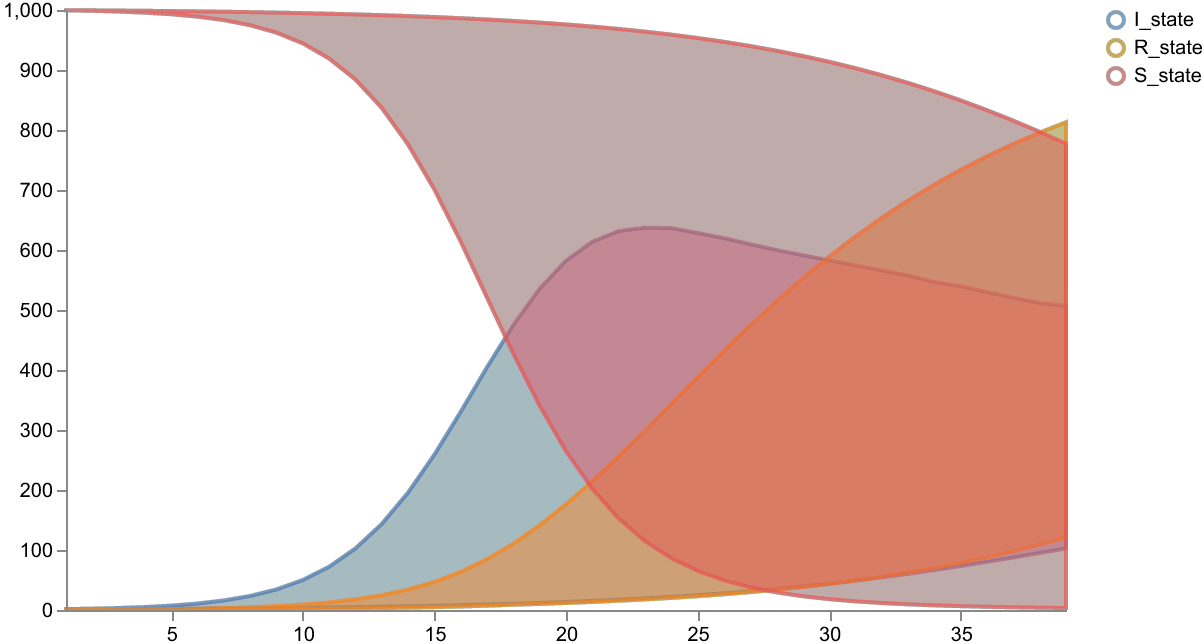

In [5]:
start_t = time.time()
sample_results1 = pyciemss.sample(
    model_opt1,
    end_time_SIR,
    logging_step_size,
    num_samples,
    start_time=start_time,
    solver_method="rk4",
    solver_options={"step_size": 1.},
)
print("Time taken: ", time.time()-start_t)
print("Risk associated with QoI:", sample_results1["risk"]["I_state"]["risk"])
# Plot results for all states
schema = plots.trajectories(sample_results1["data"], keep=".*_state", qlow=0.0, qhigh=1.0)
plots.ipy_display(schema, dpi=150)

### Baseline samples before optimization from model 2

Time taken:  5.616910696029663
Risk associated with QoI: [3543763.439999999]


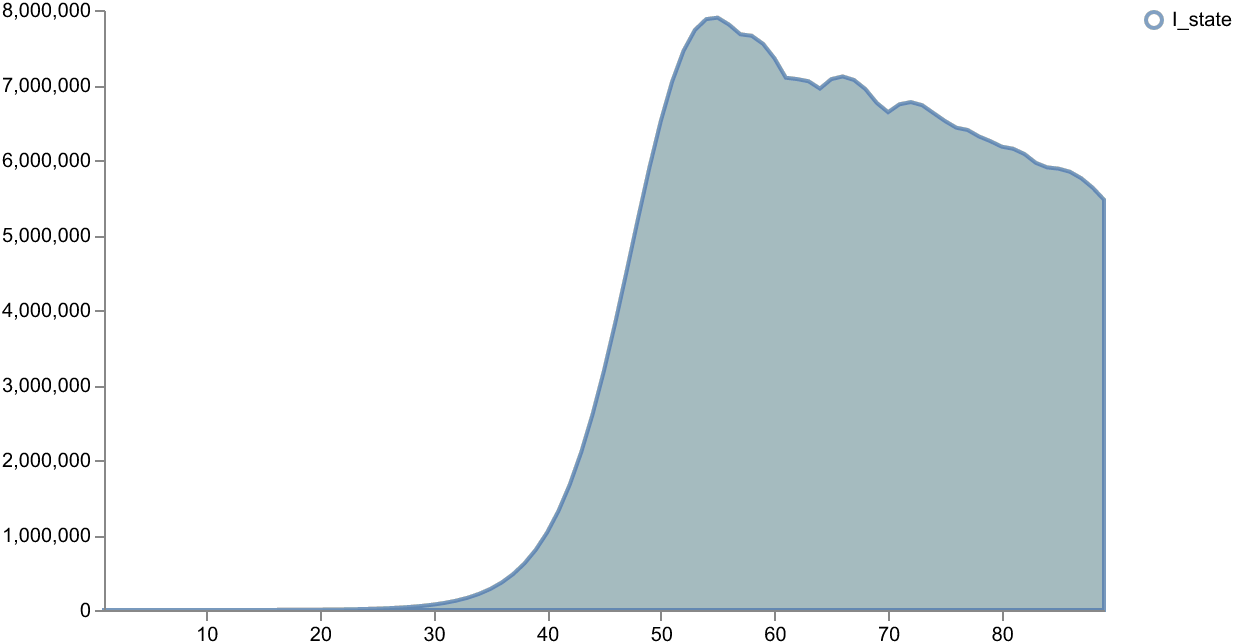

In [9]:
start_t = time.time()
sample_results2 = pyciemss.sample(
    model_opt2,
    end_time_SEIRHD,
    logging_step_size,
    num_samples,
    start_time=start_time,
    # solver_method="dopri5",
    solver_method="rk4",
    solver_options={"step_size": 1.}
)
print("Time taken: ", time.time()-start_t)
print("Risk associated with QoI:", sample_results2["risk"]["I_state"]["risk"])
# Plot results for all states
schema = plots.trajectories(sample_results2["data"], keep="I_state", qlow=0.0, qhigh=1.0)
plots.ipy_display(schema, dpi=150)

## Optimize interface with single intervention
### Optimizing a single parameter value (SIR)
Minimum change in the intervention parameter from the current value to get infections below 200 individuals at 40 days for SIR model

In [7]:
# Define optimization problem setup
observed_params = ["I_state"]
intervention_time = [torch.tensor(1.0)]
intervened_params = ["p_cbeta"]
p_cbeta_current = 0.35
initial_guess_interventions = 0.15
bounds_interventions = [[0.1], [0.5]]
static_parameter_interventions = param_value_objective(
    param_name = intervened_params,
    param_value = [lambda x: torch.tensor(x)],
    start_time = intervention_time,
)

risk_bound = 200.0
qoi = lambda y: obs_nday_average_qoi(y, observed_params, 1)
objfun = lambda x: np.abs(p_cbeta_current - x)

# Run optimize interface
opt_result1 = pyciemss.optimize(
    model_opt1,
    end_time_SIR,
    logging_step_size,
    qoi,
    risk_bound,
    static_parameter_interventions,
    objfun,
    initial_guess_interventions=initial_guess_interventions,
    bounds_interventions=bounds_interventions,
    start_time=start_time,
    n_samples_ouu=num_samples_ouu,
    maxiter=maxiter,
    maxfeval=maxfeval,
    solver_method="rk4",
    solver_options={"step_size": 1.},
)
print(f'Optimal policy:', opt_result1["policy"])
print(opt_result1)

 20%|██        | 24/120 [00:36<02:21,  1.47s/it]C:\Users\Anirban\Documents\GitHub\pyciemss\pyciemss\ouu\ouu.py:100: UserWarning: Selected interventions are out of bounds. Will use a penalty instead of estimating risk.
  warnings.warn(
 23%|██▎       | 28/120 [00:41<02:00,  1.31s/it]C:\Users\Anirban\Documents\GitHub\pyciemss\pyciemss\ouu\ouu.py:100: UserWarning: Selected interventions are out of bounds. Will use a penalty instead of estimating risk.
  warnings.warn(
 25%|██▌       | 30/120 [00:42<01:28,  1.01it/s]C:\Users\Anirban\Documents\GitHub\pyciemss\pyciemss\ouu\ouu.py:100: UserWarning: Selected interventions are out of bounds. Will use a penalty instead of estimating risk.
  warnings.warn(
 28%|██▊       | 33/120 [00:45<01:27,  1.01s/it]C:\Users\Anirban\Documents\GitHub\pyciemss\pyciemss\ouu\ouu.py:100: UserWarning: Selected interventions are out of bounds. Will use a penalty instead of estimating risk.
  warnings.warn(
C:\Users\Anirban\Documents\GitHub\pyciemss\pyciemss\ouu\ouu.

Optimal policy: tensor([0.1940], dtype=torch.float64)
{'policy': tensor([0.1940], dtype=torch.float64), 'OptResults':                     message: ['requested number of basinhopping iterations completed successfully']
                    success: True
                        fun: 0.15601673345676997
                          x: [ 1.940e-01]
                        nit: 3
      minimization_failures: 2
                       nfev: 74
 lowest_optimization_result: message: Optimization terminated successfully.
                             success: True
                              status: 1
                                 fun: 0.15601673345676997
                                   x: [ 1.940e-01]
                                nfev: 7
                               maxcv: 0.0}



C:\Users\Anirban\Documents\GitHub\pyciemss\pyciemss\interfaces.py:943: UserWarning: Optimal intervention policy satisfies constraints and is within set bounds.If better policy is desired, try(i) expanding the bounds_interventions, (ii) relaxing risk_bounds, and/or(iii) increasing maxiter and maxfeval or different initial_guess_interventions.
  warnings.warn(


#### Sample using optimal policy as intervention

Intervention:  {1.0: {'p_cbeta': tensor(0.1940)}}
Risk associated with QoI: [197.5618798828125]


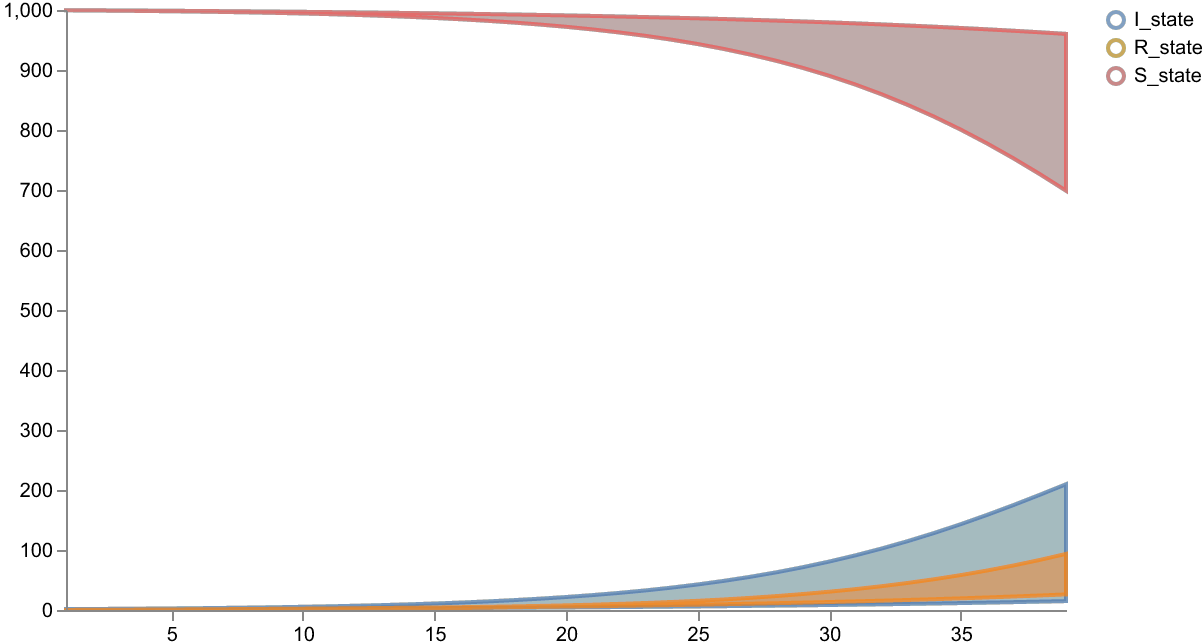

In [8]:
print("Intervention: ", static_parameter_interventions(opt_result1["policy"]))
result1 = pyciemss.sample(
    model_opt1,
    end_time_SIR,
    logging_step_size,
    num_samples,
    start_time=start_time,
    static_parameter_interventions=static_parameter_interventions(opt_result1["policy"]),
    solver_method="rk4",
    solver_options={"step_size": 1.},
)
# display(result1["data"])
print("Risk associated with QoI:", result1["risk"][observed_params[0]]["risk"])
# Plot results for all states
schema = plots.trajectories(result1["data"], keep=".*_state", qlow=0.0, qhigh=1.0)
plots.ipy_display(schema, dpi=150)


### Optimizing the start time for a single intervention (SIR)
Maximum delay in the intervention to get infections below 200 individuals at 40 days for SIR model

In [9]:
# Define optimization problem setup
observed_params = ["I_state"]
intervened_params = ["p_cbeta"]
initial_guess_interventions = 5.
bounds_interventions = [[1.], [39.]]    # bounds should be withing start_time and end_time
intervention_value = torch.tensor([0.15])
static_parameter_interventions = start_time_objective(
    param_name = intervened_params,
    param_value = intervention_value,
)

risk_bound = 200.0
qoi = lambda y: obs_nday_average_qoi(y, observed_params, 1)
objfun = lambda x: -x

# Run optimize interface
opt_result2 = pyciemss.optimize(
    model_opt1,
    end_time_SIR,
    logging_step_size,
    qoi,
    risk_bound,
    static_parameter_interventions,
    objfun,
    initial_guess_interventions=initial_guess_interventions,
    bounds_interventions=bounds_interventions,
    start_time=start_time,
    n_samples_ouu=num_samples_ouu,
    maxiter=maxiter,
    maxfeval=maxfeval,
    solver_method="rk4",
    solver_options={"step_size": 1.},
)
print(f'Optimal policy:', opt_result2["policy"])
print(opt_result2)
print("Intervention: ", static_parameter_interventions(opt_result2["policy"]))

 37%|███▋      | 44/120 [00:48<01:23,  1.10s/it]

Optimal policy: tensor([7.6958], dtype=torch.float64)
{'policy': tensor([7.6958], dtype=torch.float64), 'OptResults':                     message: ['requested number of basinhopping iterations completed successfully']
                    success: True
                        fun: -7.69576122033028
                          x: [ 7.696e+00]
                        nit: 3
      minimization_failures: 0
                       nfev: 44
 lowest_optimization_result: message: Optimization terminated successfully.
                             success: True
                              status: 1
                                 fun: -7.69576122033028
                                   x: [ 7.696e+00]
                                nfev: 10
                               maxcv: 9.765624980673238e-06}
Intervention:  {7.6958: {'p_cbeta': tensor(0.1500)}}



C:\Users\Anirban\Documents\GitHub\pyciemss\pyciemss\interfaces.py:943: UserWarning: Optimal intervention policy satisfies constraints and is within set bounds.If better policy is desired, try(i) expanding the bounds_interventions, (ii) relaxing risk_bounds, and/or(iii) increasing maxiter and maxfeval or different initial_guess_interventions.
  warnings.warn(


Risk associated with QoI: [144.8216143798828]


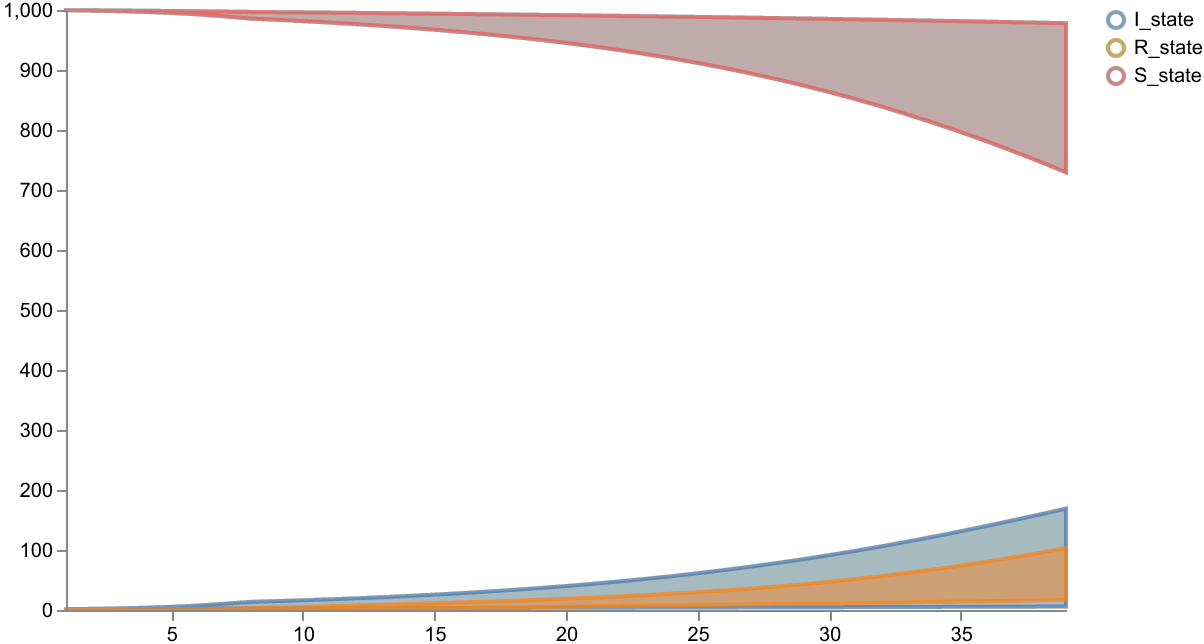

In [10]:
result2 = pyciemss.sample(
    model_opt1,
    end_time_SIR,
    logging_step_size,
    num_samples,
    start_time=start_time,
    static_parameter_interventions=static_parameter_interventions(opt_result2["policy"]),
    solver_method="euler",
    solver_options={"step_size": 1.},
)
# display(result2["data"])
# Check risk estimate used in constraints
print("Risk associated with QoI:", result2["risk"][observed_params[0]]["risk"])
# Plot results for all states
schema = plots.trajectories(result2["data"], keep=".*_state", qlow=0.0, qhigh=1.0)
plots.ipy_display(schema, dpi=150)

## Optimize interface with multiple interventions
### Optimizing multiple intervention values (SEIRHD)
Minimum change in two intervention parameters from their current values to get infections below 30000 individuals at 60 days for SEIRHD model
* Intervene on beta_c after 10 days
* Intervene on gamma after 15 days

In [11]:
# Define optimization problem setup
observed_params = ["I_state"]
intervention_time = [torch.tensor(10.0), torch.tensor(15.0)]
intervened_params = ["beta_c", "gamma"]
param_current = [0.35, 0.2]
initial_guess_interventions = [0.2, 0.4]
bounds_interventions = [[0.1, 0.1], [0.5, 0.5]]
# Note that param_value is not passed in below and defaults to None.
# User can also pass ina list of lambda x: torch.tensor(x) for each intervention.
static_parameter_interventions = param_value_objective(
    param_name=intervened_params,
    start_time=intervention_time,
)

risk_bound = 3e4
qoi = lambda y: obs_nday_average_qoi(y, observed_params, 1)
objfun = lambda x: np.sum(np.abs(param_current - x))

# Run optimize interface
opt_result3 = pyciemss.optimize(
    model_opt2,
    end_time_SEIRHD,
    logging_step_size,
    qoi,
    risk_bound,
    static_parameter_interventions,
    objfun,
    initial_guess_interventions=initial_guess_interventions,
    bounds_interventions=bounds_interventions,
    start_time=start_time,
    n_samples_ouu=num_samples_ouu,
    maxiter=maxiter,
    maxfeval=maxfeval,
    solver_method="rk4",
    solver_options={"step_size": 1.},
)
print(f"Optimal policy:", opt_result3["policy"])
print(opt_result3)

124it [06:19,  3.06s/it]                         

Optimal policy: tensor([0.3500, 0.4495], dtype=torch.float64)
{'policy': tensor([0.3500, 0.4495], dtype=torch.float64), 'OptResults':                     message: ['requested number of basinhopping iterations completed successfully']
                    success: False
                        fun: 0.2494535138541334
                          x: [ 3.500e-01  4.495e-01]
                        nit: 3
      minimization_failures: 4
                       nfev: 120
 lowest_optimization_result: message: Maximum number of function evaluations has been exceeded.
                             success: False
                              status: 2
                                 fun: 0.2494535138541334
                                   x: [ 3.500e-01  4.494e-01]
                                nfev: 30
                               maxcv: 0.0}


#### Sample using optimal policy as intervention

Intervention:  {10.0: {'beta_c': tensor(0.3500)}, 15.0: {'gamma': tensor(0.4495)}}
Risk associated with QoI: [29969.813515624985]


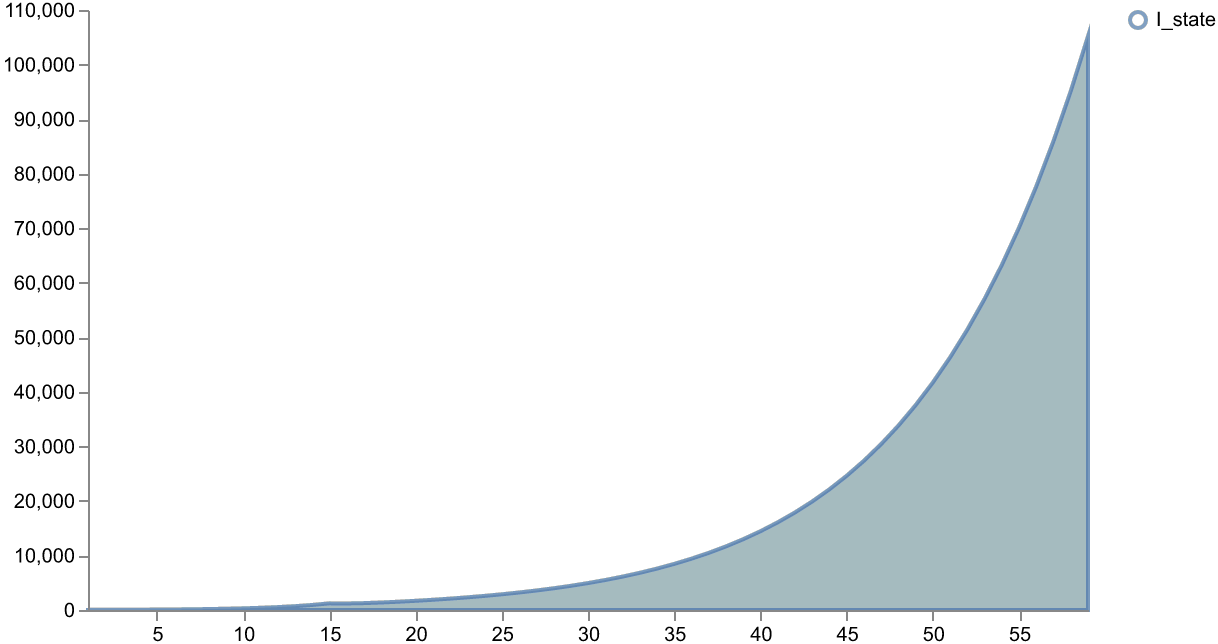

In [12]:
print("Intervention: ", static_parameter_interventions(opt_result3["policy"]))
with pyro.poutine.seed(rng_seed=0):
    result3 = pyciemss.sample(
        model_opt2,
        end_time_SEIRHD,
        logging_step_size,
        num_samples,
        start_time=start_time,
        static_parameter_interventions=static_parameter_interventions(opt_result3["policy"]),
        solver_method="rk4",
        solver_options={"step_size": 1.},
    )

# Check risk estimate used in constraints
print("Risk associated with QoI:", result3["risk"][observed_params[0]]["risk"])
# Plot results for all states
schema = plots.trajectories(result3["data"], keep="I_state", qlow=0.0, qhigh=1.0)
plots.ipy_display(schema, dpi=150)

### Optimizing for start times of multiple interventions (SEIRHD)
Maximum delay in starting two interventions to get infections below 30000 individuals at 60 days for SEIRHD model
* Intervene on beta_c to be 0.15
* Intervene on gamma to be 0.35

In [13]:
# Define optimization problem setup
observed_params = ["I_state"]
intervened_params = ["beta_c", "gamma"]
initial_guess_interventions = [torch.tensor(10.), torch.tensor(10.)]
bounds_interventions = [[1., 1.], [39., 39.]]    # bounds should be withing start_time and end_time
intervention_value = torch.tensor([0.15, 0.4])
static_parameter_interventions = start_time_objective(
    param_name = intervened_params,
    param_value = intervention_value,
)

risk_bound = 3e4
qoi = lambda y: obs_nday_average_qoi(y, observed_params, 1)
objfun = lambda x: -np.sum(np.abs(x))

# Run optimize interface
opt_result4 = pyciemss.optimize(
    model_opt2,
    end_time_SEIRHD,
    logging_step_size,
    qoi,
    risk_bound,
    static_parameter_interventions,
    objfun,
    initial_guess_interventions=initial_guess_interventions,
    bounds_interventions=bounds_interventions,
    start_time=start_time,
    n_samples_ouu=num_samples_ouu,
    maxiter=maxiter,
    maxfeval=maxfeval,
    solver_method="rk4",
    solver_options={"step_size": 1.},
)
print(f'Optimal policy:', opt_result4["policy"])
print(opt_result4)
print("Intervention: ", static_parameter_interventions(opt_result4["policy"]))

  8%|▊         | 9/120 [00:26<05:05,  2.75s/it]C:\Users\Anirban\Documents\GitHub\pyciemss\pyciemss\ouu\ouu.py:100: UserWarning: Selected interventions are out of bounds. Will use a penalty instead of estimating risk.
  warnings.warn(
 10%|█         | 12/120 [00:32<04:00,  2.23s/it]C:\Users\Anirban\Documents\GitHub\pyciemss\pyciemss\ouu\ouu.py:100: UserWarning: Selected interventions are out of bounds. Will use a penalty instead of estimating risk.
  warnings.warn(
 12%|█▎        | 15/120 [00:37<03:34,  2.04s/it]C:\Users\Anirban\Documents\GitHub\pyciemss\pyciemss\ouu\ouu.py:100: UserWarning: Selected interventions are out of bounds. Will use a penalty instead of estimating risk.
  warnings.warn(
 14%|█▍        | 17/120 [00:40<03:03,  1.78s/it]C:\Users\Anirban\Documents\GitHub\pyciemss\pyciemss\ouu\ouu.py:100: UserWarning: Selected interventions are out of bounds. Will use a penalty instead of estimating risk.
  warnings.warn(
 17%|█▋        | 20/120 [00:45<03:05,  1.86s/it]C:\Users\Anir

Optimal policy: tensor([39.0000,  6.0327], dtype=torch.float64)
{'policy': tensor([39.0000,  6.0327], dtype=torch.float64), 'OptResults':                     message: ['requested number of basinhopping iterations completed successfully']
                    success: False
                        fun: -45.032607877335636
                          x: [ 3.900e+01  6.033e+00]
                        nit: 3
      minimization_failures: 4
                       nfev: 120
 lowest_optimization_result: message: Did not converge to a solution satisfying the constraints. See `maxcv` for magnitude of violation.
                             success: False
                              status: 4
                                 fun: -45.032607877335636
                                   x: [ 3.900e+01  6.033e+00]
                                nfev: 30
                               maxcv: 0.006562499991559889}
Intervention:  {39.0: {'beta_c': tensor(0.1500)}, 6.0327: {'gamma': tensor(0.4000)}}



C:\Users\Anirban\Documents\GitHub\pyciemss\pyciemss\interfaces.py:956: UserWarning: Optimal intervention policy does not satisfy constraints.Check if the risk_bounds value is appropriate for given problem.Otherwise, try (i) different initial_guess_interventions, (ii) increasing maxiter/maxfeval,and/or (iii) increase n_samples_ouu to improve accuracy of Monte Carlo risk estimation. 
  warnings.warn(


Intervention:  {39.0: {'beta_c': tensor(0.1500)}, 6.0327: {'gamma': tensor(0.4000)}}
Time taken:  7.552547931671143
Risk associated with QoI: [30000.24984374999]


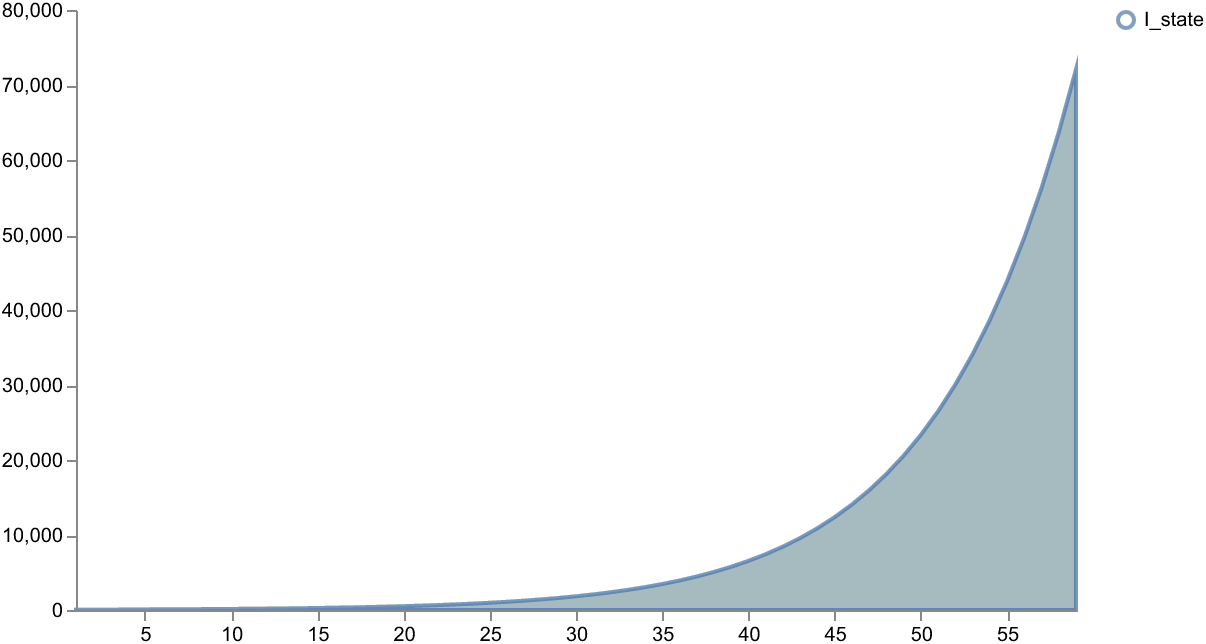

In [14]:
print("Intervention: ", static_parameter_interventions(opt_result4["policy"]))
start_t = time.time()
with pyro.poutine.seed(rng_seed=0):
    result4 = pyciemss.sample(
        model_opt2,
        end_time_SEIRHD,
        logging_step_size,
        num_samples,
        start_time=start_time,
        static_parameter_interventions=static_parameter_interventions(opt_result4["policy"]),
        solver_method="rk4",
        # solver_method="euler",
        solver_options={"step_size":1.},
    )
print("Time taken: ", time.time()-start_t)
# Check risk estimate used in constraints
print("Risk associated with QoI:", result4["risk"][observed_params[0]]["risk"])
# Plot results for all states
schema = plots.trajectories(result4["data"], keep="I_state", qlow=0.0, qhigh=1.0)
plots.ipy_display(schema, dpi=150)

Intervention:  {39.0: {'beta_c': tensor(0.1500)}, 6.0327: {'gamma': tensor(0.4000)}}
Time taken:  12.033756732940674
Risk associated with QoI: [28489.04578124999]


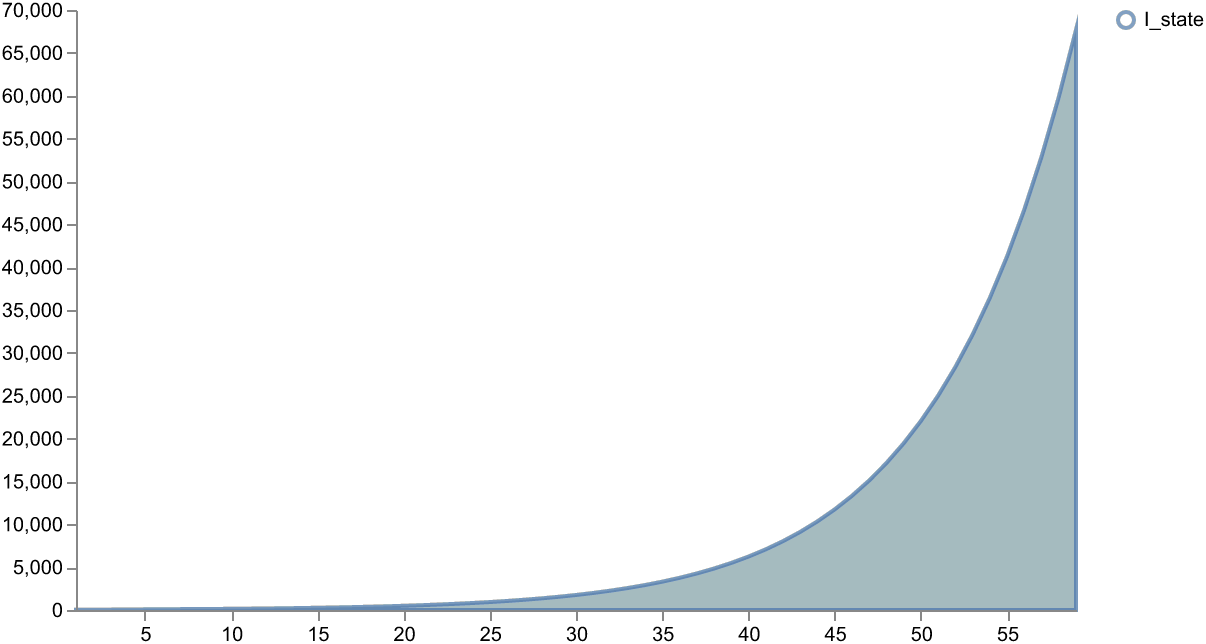

In [15]:
print("Intervention: ", static_parameter_interventions(opt_result4["policy"]))
start_t = time.time()
with pyro.poutine.seed(rng_seed=0):
    result4 = pyciemss.sample(
        model_opt2,
        end_time_SEIRHD,
        logging_step_size,
        num_samples,
        start_time=start_time,
        static_parameter_interventions=static_parameter_interventions(opt_result4["policy"]),
        solver_method="euler",
        solver_options={"step_size": 0.1},
    )
print("Time taken: ", time.time()-start_t)
# Check risk estimate used in constraints
print("Risk associated with QoI:", result4["risk"][observed_params[0]]["risk"])
# Plot results for all states
schema = plots.trajectories(result4["data"], keep="I_state", qlow=0.0, qhigh=1.0)
plots.ipy_display(schema, dpi=150)

Intervention:  {39.0: {'beta_c': tensor(0.1500)}, 6.0327: {'gamma': tensor(0.4000)}}
Time taken:  14.085338592529297
Risk associated with QoI: [30001.24765624999]


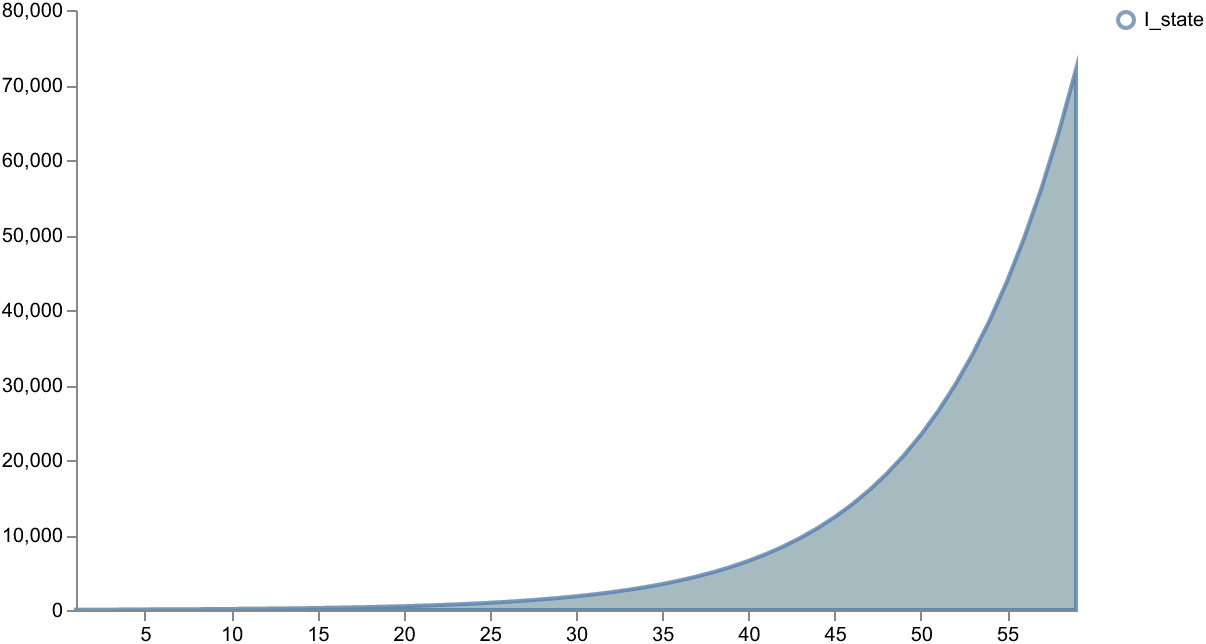

In [16]:
print("Intervention: ", static_parameter_interventions(opt_result4["policy"]))
start_t = time.time()
with pyro.poutine.seed(rng_seed=0):
    result4 = pyciemss.sample(
        model_opt2,
        end_time_SEIRHD,
        logging_step_size,
        num_samples,
        start_time=start_time,
        static_parameter_interventions=static_parameter_interventions(opt_result4["policy"]),
        solver_method="dopri5",
    )
print("Time taken: ", time.time()-start_t)
# Check risk estimate used in constraints
print("Risk associated with QoI:", result4["risk"][observed_params[0]]["risk"])
# Plot results for all states
schema = plots.trajectories(result4["data"], keep="I_state", qlow=0.0, qhigh=1.0)
plots.ipy_display(schema, dpi=150)

## Optimize interface with multiple interventions and QoI defined as max over range of simulated time
### Optimizing multiple intervention values (SEIRHD) and max QoI over simulated time
Minimum change in two intervention parameters from their current values to get infections below 300,000 individuals betweeen 0-90 days for SEIRHD model
* Intervene on beta_c after 10 days
* Intervene on gamma after 15 days

In [24]:
# Define optimization problem setup
observed_params = ["I_state"]
intervention_time = [torch.tensor(10.0), torch.tensor(15.0)]
intervened_params = ["beta_c", "gamma"]
param_current = [0.35, 0.2]
initial_guess_interventions = [0.2, 0.4]
bounds_interventions = [[0.1, 0.1], [0.5, 0.5]]
# Note that param_value is not passed in below and defaults to None.
# User can also pass ina list of lambda x: torch.tensor(x) for each intervention.
static_parameter_interventions = param_value_objective(
    param_name=intervened_params,
    start_time=intervention_time,
)

risk_bound = 3e5
qoi = lambda y: obs_max_qoi(y, observed_params)
objfun = lambda x: np.sum(np.abs(param_current - x))

# Run optimize interface
opt_result5 = pyciemss.optimize(
    model_opt2,
    end_time_SEIRHD2,
    logging_step_size,
    qoi,
    risk_bound,
    static_parameter_interventions,
    objfun,
    initial_guess_interventions=initial_guess_interventions,
    bounds_interventions=bounds_interventions,
    start_time=start_time,
    n_samples_ouu=num_samples_ouu,
    maxiter=maxiter,
    maxfeval=maxfeval,
    solver_method="rk4",
    solver_options={"step_size": 1.0},
)
print(f"Optimal policy:", opt_result5["policy"])
print(opt_result5)

 27%|██▋       | 32/120 [02:44<07:07,  4.86s/it]C:\Users\Anirban\Documents\GitHub\pyciemss\pyciemss\ouu\ouu.py:100: UserWarning: Selected interventions are out of bounds. Will use a penalty instead of estimating risk.
  warnings.warn(
 52%|█████▎    | 63/120 [05:54<05:21,  5.65s/it]C:\Users\Anirban\Documents\GitHub\pyciemss\pyciemss\ouu\ouu.py:100: UserWarning: Selected interventions are out of bounds. Will use a penalty instead of estimating risk.
  warnings.warn(
 79%|███████▉  | 95/120 [09:07<02:15,  5.43s/it]C:\Users\Anirban\Documents\GitHub\pyciemss\pyciemss\ouu\ouu.py:100: UserWarning: Selected interventions are out of bounds. Will use a penalty instead of estimating risk.
  warnings.warn(
124it [11:53,  5.75s/it]                         

Optimal policy: tensor([0.3500, 0.4602], dtype=torch.float64)
{'policy': tensor([0.3500, 0.4602], dtype=torch.float64), 'OptResults':                     message: ['requested number of basinhopping iterations completed successfully']
                    success: False
                        fun: 0.26016707274061507
                          x: [ 3.500e-01  4.602e-01]
                        nit: 3
      minimization_failures: 4
                       nfev: 120
 lowest_optimization_result: message: Maximum number of function evaluations has been exceeded.
                             success: False
                              status: 2
                                 fun: 0.26016707274061507
                                   x: [ 3.500e-01  4.601e-01]
                                nfev: 30
                               maxcv: 0.0}


#### Sample using optimal policy as intervention

Intervention:  {10.0: {'beta_c': tensor(0.3500)}, 15.0: {'gamma': tensor(0.4602)}}
Risk associated with QoI: [299594.7449999999]


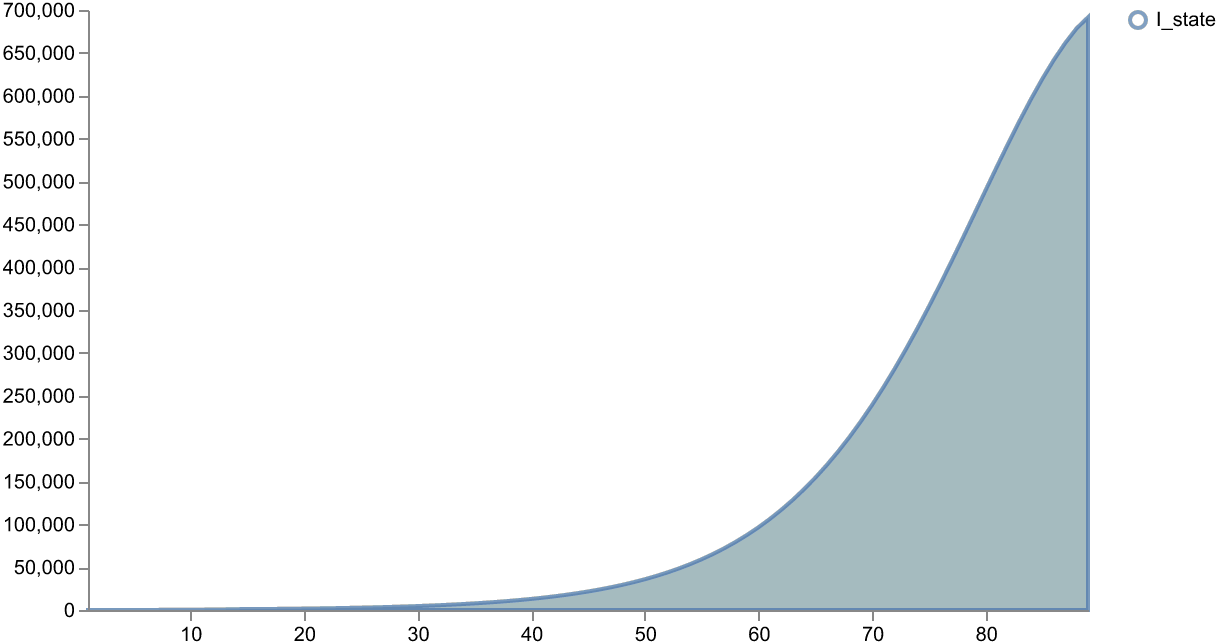

In [25]:
print("Intervention: ", static_parameter_interventions(opt_result5["policy"]))
with pyro.poutine.seed(rng_seed=0):
    result5 = pyciemss.sample(
        model_opt2,
        end_time_SEIRHD2,
        logging_step_size,
        num_samples,
        start_time=start_time,
        static_parameter_interventions=static_parameter_interventions(opt_result5["policy"]),
        solver_method="rk4",
        solver_options={"step_size": 1.},
    )

# Check risk estimate used in constraints
print("Risk associated with QoI:", result5["risk"][observed_params[0]]["risk"])
# Plot results for all states
schema = plots.trajectories(result5["data"], keep="I_state", qlow=0.0, qhigh=1.0)
plots.ipy_display(schema, dpi=150)